

<img src="https://drive.google.com/uc?export=view&id=1wpQMFbiopOgqZ8MMseUDCorEhxWVu9FM" width="450" height="400" align='right' />


## Amirkabir Artificial Intelligence Summer Summit

### Generative Adversarial Networks Workshop



#### Mohammad Rahmdel

www.github.com/Mohammad-Rahmdel


##### Amirkabir Artificial Intelligence Summer Summit
##### Computer Engineering Department of Amirkabir University of Technology




In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
tf.random.set_seed(4)

In [3]:
DIM = (28,28,1)
batch_size = 128
n_classes = 10
n_z = 100
n_epochs = 10000

lr = 0.0002 
beta_1 = 0.5

In [4]:
(train_images, labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Conditional GAN (CGAN)



<img src="https://drive.google.com/uc?export=view&id=1UZ6VScxJ0ncDNLfm0QDIOQNsZo5cmFpV" width="600" height="400" />

In [5]:
print(labels[:5])
print(labels.shape)

[5 0 4 1 9]
(60000,)


In [6]:
labels = tf.one_hot(labels, n_classes)

print(labels[:5])
print(labels.shape)

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)
(60000, 10)


In [7]:
train_images = train_images.reshape(train_images.shape[0], DIM[0]*DIM[1]*DIM[2]).astype('float32') / 255.0 ## [0-1]
train_images = train_images * 2 - 1 ## [0,1] to [-1,1]

In [8]:
train_images.shape

(60000, 784)

In [9]:
train_data = tf.concat([train_images, labels], axis=-1)
print(train_data.shape)

(60000, 794)


In [10]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data)
    .shuffle(train_data.shape[0])
    .batch(batch_size)
)

In [11]:
G_optimizer = tf.keras.optimizers.Adam(lr, beta_1)
D_optimizer = tf.keras.optimizers.Adam(lr, beta_1)

In [12]:
D = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(DIM[0]*DIM[1]*DIM[2]+n_classes)),
        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               407040    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

In [13]:
G = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_z + n_classes)),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(DIM[0]*DIM[1]*DIM[2], activation='tanh')
])

G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               28416     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)             

In [14]:
loss = tf.keras.losses.binary_crossentropy


<img src="https://drive.google.com/uc?export=view&id=1H7ltMKYdcOezJHTTXAxWRvErb4Z39BRK" width="850" height="400" />


In [15]:
# tf.config.experimental_run_functions_eagerly(True)

In [16]:
@tf.function
def train_D(x_real):
    with tf.GradientTape() as tape:
        z = tf.random.normal(shape=(x_real.shape[0], n_z))
        label = x_real[:,-(n_classes):]
        z_conditioned = tf.concat([z, label], axis=-1)
        
        x_fake = G(z_conditioned, training=True)
        x_fake_conditioned = tf.concat([x_fake, label], axis=-1)
        
        D_x_real = D(x_real, training=True)
        D_x_fake = D(x_fake_conditioned, training=True)
        
        d1 = loss(tf.ones_like(D_x_real), D_x_real)
        d2 = loss(tf.zeros_like(D_x_fake), D_x_fake)

        D_loss = d1 + d2


    D_gradients = tape.gradient(D_loss, D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, D.trainable_variables))
    
    return tf.reduce_mean(d1), tf.reduce_mean(d2)

In [17]:
@tf.function
def train_G(x_real):
    with tf.GradientTape() as tape:

        z = tf.random.normal(shape=(x_real.shape[0], n_z))
        label = x_real[:,-(n_classes):]
        z_conditioned = tf.concat([z, label], axis=-1)
        
        x_gen = G(z_conditioned, training=True)
        x_gen_conditioned = tf.concat([x_gen, label], axis=-1)
        
        D_x_gen = D(x_gen_conditioned, training=True)
        G_loss = loss(tf.ones_like(D_x_gen), D_x_gen)

    G_gradients = tape.gradient(G_loss, G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))

    return tf.reduce_mean(G_loss)

In [18]:
def generate_and_plot(rows=8, scale=1.5, seed=None):
    cols = 10
    if seed!=None:
        tf.random.set_seed(seed)

    plt.figure(figsize=(scale*cols, scale*rows))
    z = tf.random.normal(shape=(cols*rows, n_z))

    condition = np.zeros((rows*cols,), dtype='int32')
    for i in range(rows):
        for j in range(cols): 
            condition[j + i * cols] = j

    condition = tf.one_hot(condition, n_classes)

    z_conditioned = tf.concat([z, condition], axis=-1)

    images = G(z_conditioned, training=False)
    
    for i in range(rows):
        for j in range(cols):
            plt.subplot(rows, cols, j + i * cols + 1)
            plt.axis('off')
            plt.imshow(tf.reshape(images[j + i * cols], shape=(DIM[0],DIM[1])), cmap=plt.cm.Greys)
    plt.show()

In [19]:
GLosses = []
DLosses_f = []
DLosses_r = []

In [20]:
def train(n_epochs=1, print_=False):
    t1 = time.time()

    for epoch in range(n_epochs):
        Gloss = []
        Dloss_fake = []
        Dloss_real = []
        for batch in train_dataset:

            D_loss1, D_loss2 = train_D(batch)
            G_loss = train_G(batch)

            Gloss.append(G_loss) 
            Dloss_fake.append(D_loss2)
            Dloss_real.append(D_loss1)
        
        DLosses_f.append(np.mean(Dloss_fake))
        DLosses_r.append(np.mean(Dloss_real))
        GLosses.append(np.mean(Gloss))

        if print_:
            print(
            "Epoch: {} | disc_loss_real: {} | disc_loss_fake: {} | gen_loss: {}".format(
                epoch, GLosses[-1], DLosses_f[-1], DLosses_r[-1]
            ))
    
    t2 = time.time()
    print('total train time: ', t2 - t1)

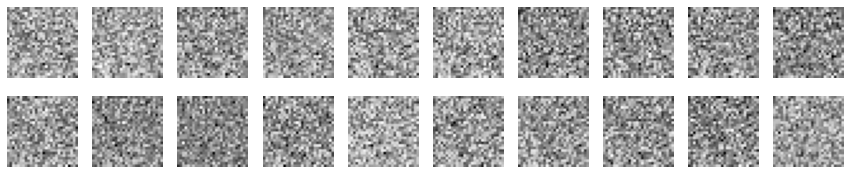

In [21]:
generate_and_plot(2)

In [23]:
train(10, True)
# train(100, False)

Epoch: 0 | disc_loss_real: 0.9852877855300903 | disc_loss_fake: 0.605685293674469 | gen_loss: 0.6107441782951355
Epoch: 1 | disc_loss_real: 0.9481130838394165 | disc_loss_fake: 0.6174730062484741 | gen_loss: 0.6225728392601013
Epoch: 2 | disc_loss_real: 0.9304516315460205 | disc_loss_fake: 0.6227166652679443 | gen_loss: 0.6276004910469055
Epoch: 3 | disc_loss_real: 0.9153916239738464 | disc_loss_fake: 0.6273782849311829 | gen_loss: 0.634785532951355
Epoch: 4 | disc_loss_real: 0.9008787274360657 | disc_loss_fake: 0.633998453617096 | gen_loss: 0.6389998197555542
Epoch: 5 | disc_loss_real: 0.8813961744308472 | disc_loss_fake: 0.6386865377426147 | gen_loss: 0.642768919467926
Epoch: 6 | disc_loss_real: 0.8796431422233582 | disc_loss_fake: 0.6384238004684448 | gen_loss: 0.6444849371910095
Epoch: 7 | disc_loss_real: 0.868069052696228 | disc_loss_fake: 0.6452113389968872 | gen_loss: 0.649145245552063
Epoch: 8 | disc_loss_real: 0.8593887686729431 | disc_loss_fake: 0.6472658514976501 | gen_loss:

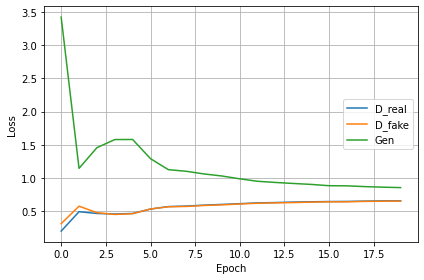

In [24]:
plt.plot(DLosses_r, label="D_real")
plt.plot(DLosses_f, label="D_fake")
plt.plot(GLosses, label="Gen")
plt.legend(loc=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

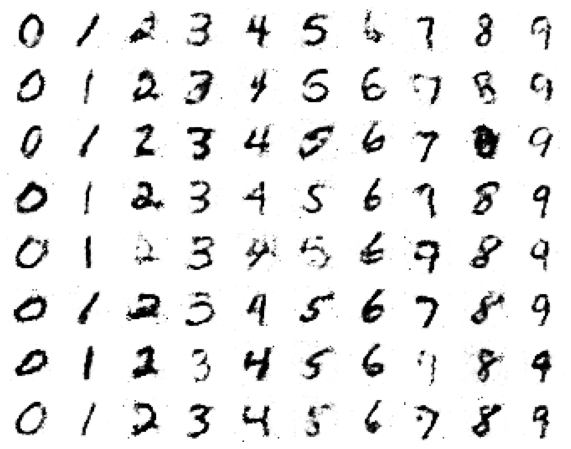

In [25]:
generate_and_plot(8, scale=1)